# Training neural networks with CBO

This notebook shows how to train a simple neural network on the MNIST dataset. We employ [Pytorch](https://pytorch.org/), which creates a very convenient machine learning environment. In particular, we will see how CBX can run on the GPU. 

We start by loading the necessary packages.

In [1]:
%load_ext autoreload
%autoreload 2
import cbx as cbx
from cbx.dynamics import CBO
from mirrorcbx.dynamics import MirrorCBO
import torch
import torch.nn as nn
import torchvision
import cbx.utils.resampling as rsmp

## Load the data: MNIST
We load the train and test data. In this case we use the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, which we assume to be available. You can specify the path with the variable ``data_path`` to point to the right directory.

In [2]:
data_path = "../../../../datasets/" # This path directs to one level above the CBX package
transform = torchvision.transforms.ToTensor()
train_data = torchvision.datasets.MNIST(data_path, train=True, transform=transform, download=False)
test_data = torchvision.datasets.MNIST(data_path, train=False, transform=transform, download=False)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64,shuffle=False, num_workers=0)

## Specify the device

We now specify the device to run everything on. If [cuda](https://developer.nvidia.com/cuda-toolkit) is available, we perform most of the calculations on the GPU!

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load model type

We now load the model that we want to employ in the following. The variable ``model_class`` specifies the kind of network we want to use, in this case a Perceptron with one hidden layer. Since


In [4]:
from models import Perceptron
model_class = Perceptron

In [5]:
from cbx.utils.torch_utils import flatten_parameters, get_param_properties, eval_losses, norm_torch, compute_consensus_torch, standard_normal_torch, eval_acc, effective_sample_size
N = 100
models = [model_class(sizes=[784,10]) for _ in range(N)]
model = models[0]
pnames = [p[0] for p in model.named_parameters()]
w = flatten_parameters(models, pnames).to(device)
pprop = get_param_properties(models, pnames=pnames)

## The objective function

We now define the functions that we want to optimize. For a single particle $w_i$ it is defined as 

$$f(w_i) := \sum_{(x,y)\in\mathcal{T}} \ell(N_{w_i}(x), y),$$

where $\mathcal{T}$ is our training set, $N_{w_i}$ denotes the neural net parametrized by $w_i$ and $\ell$ is some loss function. We usually do not evaluate the loss on the whole training set, but rather on so called mini-batches $B\subset\mathcal{T}$ which is incorporated in the objective function below.

In [6]:
class objective:
    def __init__(self, train_loader, N, device, model, pprop, lamda=0.1):
        self.train_loader = train_loader
        self.data_iter = iter(train_loader)
        self.N = N
        self.epochs = 0
        self.device = device   
        self.loss_fct = nn.CrossEntropyLoss()
        self.model = model
        self.pprop = pprop
        self.set_batch()
        self.lamda = lamda
        
    def __call__(self, w):   
        return eval_losses(self.x, self.y, self.loss_fct, self.model, w[0,...], self.pprop) + self.reg(w)

    def reg(self, w):
        if self.lamda > 0:
            return self.lamda * (w==0).sum(axis=-1)
        else:
            return 0
    
    def set_batch(self,):
        (x,y) = next(self.data_iter, (None, None))
        if x is None:
            self.data_iter = iter(self.train_loader)
            (x,y) = next(self.data_iter)
            self.epochs += 1
        self.x = x.to(self.device)
        self.y = y.to(self.device)

## Set up CBX Dynamic

We now set up the dynamic. First we set some parameters.

In [7]:
kwargs = {
    'alpha':50.0,
    'dt': 0.1,
    'sigma': 0.1,
    'lamda': 1.0,
    'max_it': 200,
    'verbosity':0,
    'batch_args':{'batch_size':10, 'batch_partial':False},
    'check_f_dims': False,
    'f_dim':'3D',
    'noise':'anisotropic',
    'device':device
}

In [8]:
class ElasticNetTorch:
    def __init__(self, delta=1.0, lamda=1.0):
        super().__init__()
        self.delta = delta
        self.lamda = lamda
    
    def __call__(self,theta):
        return (1/(2*self.delta))*torch.sum(theta**2, axis=-1) + self.lamda*torch.sum(np.abs(theta), axis=-1)
    
    def grad(self, theta):
        return (1/(self.delta))*theta + self.lamda * torch.sign(theta)
    
    def grad_conj(self, y):
        return self.delta * torch.sign(y) * torch.clamp((torch.abs(y) - self.lamda), min=0)

In [9]:
spr = 0
if spr> 0: w.ravel()[torch.multinomial(torch.ones(w.numel()), int((spr/100) * w.shape[-1]) * N)] = 0.

In [17]:
from cbx.utils.torch_utils import to_torch_dynamic
f = objective(train_loader, N, device, model, pprop, lamda=0.)
resampling =  rsmp.resampling([rsmp.consensus_stagnation(patience=1)], var_name='y')
#resampling =  rsmp.resampling([rsmp.loss_update_resampling(wait_thresh=40)])

dyn = to_torch_dynamic(MirrorCBO)(
    f, 
    x=w[None,...], 
    post_process = lambda dyn: resampling(dyn),
    mirrormap = ElasticNetTorch(lamda=.5),
    **kwargs)
sched = effective_sample_size(maximum=1e7, name='alpha')

In [18]:
e = 0
while f.epochs < 10:
    dyn.step()
    sched.update(dyn)
    f.set_batch()
    if e != f.epochs:
        e = f.epochs
        print(30*'<>')
        print('Epoch: ' +str(f.epochs))
        acc = eval_acc(model, dyn.best_particle[0, ...], pprop, test_loader)
        sp = ((dyn.best_particle[0,...]==0).sum()/dyn.d[0])
        print('Accuracy: ' + str(acc.item()))
        print('Sparsity: ' + str(sp.item()))
        print(30*'==')

<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 1
Accuracy: 0.5080999732017517
Sparsity: 0.8025413155555725
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 2
Accuracy: 0.6965000033378601
Sparsity: 0.7771283388137817
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 3
Accuracy: 0.7865999937057495
Sparsity: 0.7557814717292786
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 4
Accuracy: 0.8084999918937683
Sparsity: 0.7354511022567749
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 5
Accuracy: 0.8222999572753906
Sparsity: 0.7123252749443054
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 6
Accuracy: 0.8334999680519104
Sparsity: 0.7073698043823242
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 7
Accuracy: 0.8470999598503113
Sparsity: 0.6866582036018372
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 8
Accuracy: 0.8470999598503113
Spars

In [25]:
ww = dyn.best_particle[0,...]

In [70]:
W = ww[:784*10].reshape(10,28,28).cpu()

In [38]:
import matplotlib.pyplot as plt 

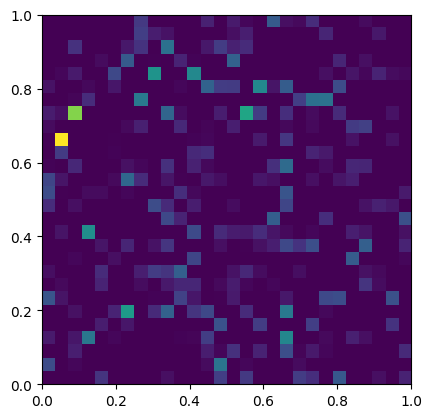

In [55]:
plt.imshow(W.cpu().abs()[9,...], extent=[0,1,0,1])

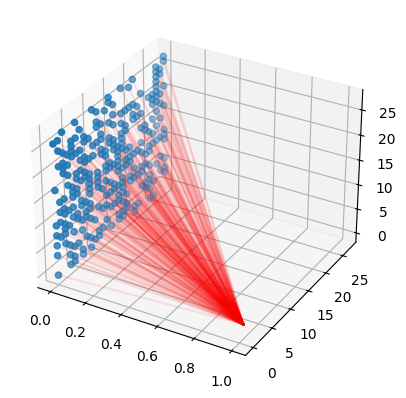

In [110]:
ax = plt.figure().add_subplot(projection='3d')
XX = torch.stack(torch.meshgrid(*[torch.arange(0,28) for _ in [0,1]]), dim=0)
Y = XX[:, W[0,:,:] !=0]
ax.scatter(0, Y[0,:], Y[1,:])
YY  = torch.cat([torch.zeros_like(Y[0:1,:]), Y])
for i in range(Y.shape[-1]):
    ax.plot(*list(torch.stack([YY[:,i], torch.ones(3)]).T), color='r', alpha=0.1)

In [107]:
list(torch.stack([YY[:,i], torch.ones(3)]).T)

[tensor([0., 1.]), tensor([0., 1.]), tensor([0., 1.])]

torch.Size([2, 262])

In [69]:
W

tensor([[[-1.4034e-01, -0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
          -6.6289e-02,  0.0000e+00],
         [-0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
          -1.6622e-01, -0.0000e+00],
         [ 0.0000e+00, -0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
          -0.0000e+00,  7.8529e-04],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  4.2594e-02,
           4.9547e-02,  0.0000e+00],
         [-0.0000e+00,  0.0000e+00, -0.0000e+00,  ...,  1.6984e-01,
          -0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
          -1.8260e-01,  2.2870e-04]],

        [[-7.0262e-02,  0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
           0.0000e+00, -0.0000e+00],
         [ 0.0000e+00, -0.0000e+00,  0.0000e+00,  ...,  2.3544e-02,
          -6.0329e-02, -0.0000e+00],
         [-2.1956e-01,  0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
           4.7612e-02,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0

In [67]:
XX.shape

torch.Size([2, 28, 28])

In [65]:
[torch.meshgrid(torch.arange(0,28)) for _ in [0,1]]

[(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),),
 (tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),)]